# td3

In [1]:
# == recnn ==
import recnn
from psychrs_utils import *

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

tqdm.pandas()

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

In [2]:
frame_size = 10
batch_size = 32

dirs = recnn.data.env.DataPath(
    base="psychdata/",
    embeddings="default_128_emb.pkl",
    ratings="psychdata.csv",
    cache="cache/frame_env.pkl",
    use_cache=True
)

env = recnn.data.env.FrameEnv(dirs, frame_size, batch_size,
                             prepare_dataset=prepare_psych_dataset,
                             test_size=0.05)


In [3]:
# test function
def run_tests():
    batch = next(iter(env.test_dataloader))
    loss = td3.update(batch, learn=False)
    return loss

value1_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
value2_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1)

cuda = torch.device('cpu')
td3 = recnn.nn.TD3(policy_net, value1_net, value2_net)
td3 = td3.to(cuda)

from time import gmtime, strftime
td3.writer = SummaryWriter(log_dir='runs/td3_{}/'.format(strftime("%m-%d_%H:%M", gmtime())))
plotter = recnn.utils.Plotter(td3.loss_layout, [['value1', 'value2'],['policy']],)

step 2900


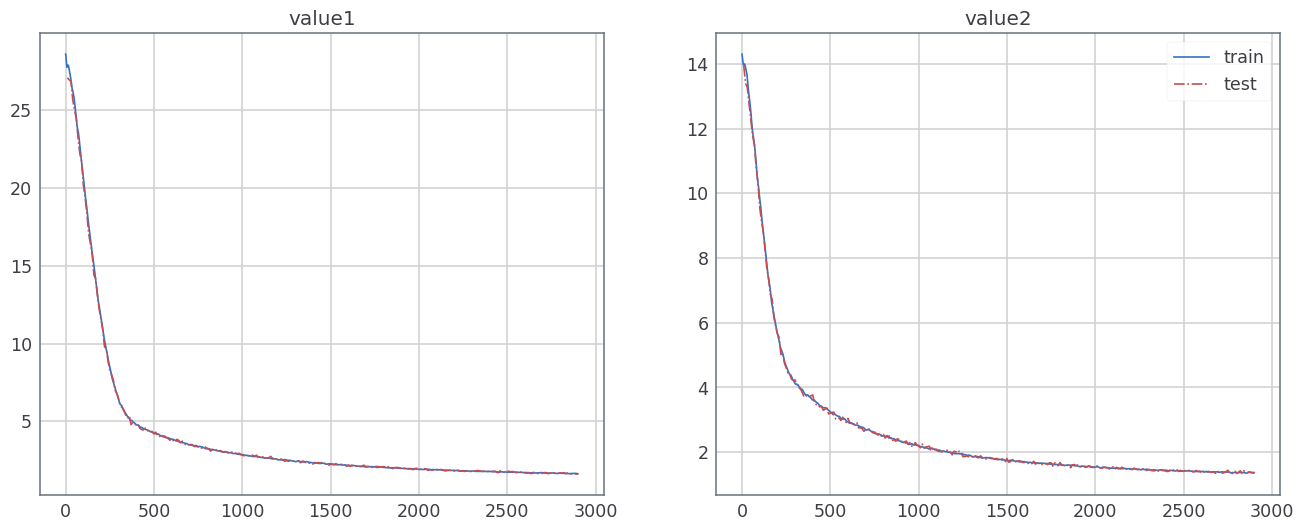

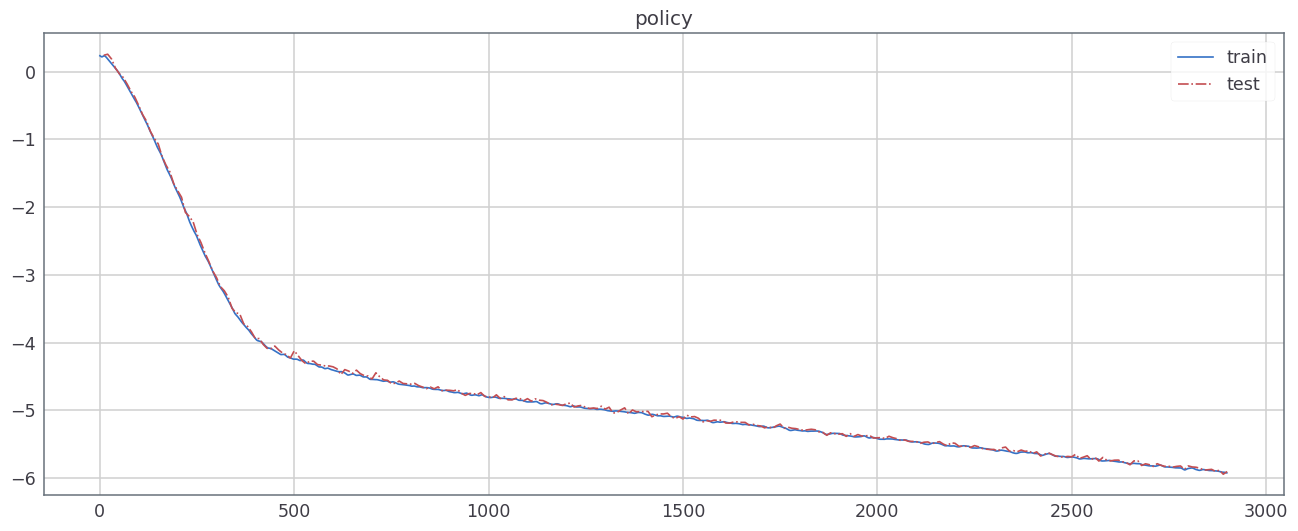

In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plot_every = 10
n_epochs = 100
td3._step = 0

def learn():
    for epoch in range(n_epochs):
        for batch in tqdm(env.train_dataloader):
            loss = td3.update(batch, learn=True)
            plotter.log_losses(loss)
            td3.step()
            if td3._step % plot_every == 0:
                clear_output(True)
                print('step', td3._step)
                test_loss = run_tests()
                plotter.log_losses(test_loss, test=True)
                plotter.plot_loss()
            if td3._step > 4000: # adjust when it needs to stop
                return
            
learn()

In [5]:
torch.save(td3.nets['policy_net'].state_dict(), 'models/td3_policy.model')
torch.save(td3.nets['value_net1'].state_dict(), 'models/td3_value1.model')
torch.save(td3.nets['value_net2'].state_dict(), 'models/td3_value2.model')

In [6]:
from scipy import stats

rs = []

for batch in tqdm(env.test_dataloader):
    state, action, reward, next_state, _ = recnn.data.get_base_batch(batch, device='cpu')
    recommendation = td3.nets['policy_net'](state)
    for r, a in zip(recommendation, action):
        rs.append(stats.pearsonr(r.detach().numpy(), a.detach().numpy()))
    
print(np.mean(rs))

  0%|          | 0/2 [00:00<?, ?it/s]

0.21915656445463358
